In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
exp_s = Experiment(
    "ERA5", "plev", "s", "6H", "all", "JJA", -80, 30, 20, 80, [200, 250, 300, 350], None, None, None, reduce_da=True
)
da_s = exp_s.da
# exp = MultiVarExperiment("ERA5", "plev", ["u", "v", "s"], "6H", "all", None, -80, 30, 20, 80, [150, 200, 250, 300, 350])
# all_jets, where_are_jets, all_jets_one_array, all_jets_over_time, flags = exp.track_jets()
# props_as_ds_uncat = exp.props_as_ds(False)
# props_as_ds = exp.props_as_ds(True)
# props_as_ds["nao"] = get_nao(props_as_ds)
# jet_pos_da = jet_position_as_da(exp.ds["s"], props_as_ds, props_as_ds_uncat, all_jets, exp.path)
# overlap = (jet_pos_da > 0).any("lat").all("jet")
# props_as_ds["double_jet_index"] = overlap.sel(lon=slice(-20, None, None)).mean("lon")
# props_as_ds_summer = props_as_ds.sel(time=props_as_ds.time.dt.season=="JJA")
# ld = np.load(exp_s.path.joinpath("ld_100.npy"))
# theta = np.load(exp_s.path.joinpath("theta_100.npy"))

## compute CDSK indices

In [25]:
from CDSK import dynamical_local_indexes
X, da = exp_s.prepare_for_clustering()
X = exp_s.pca_transform(X, 100)
ld, theta, alpha = dynamical_local_indexes(X, n_jobs=10)
np.save(exp_s.path.joinpath("ld_100"), ld.squeeze())
np.save(exp_s.path.joinpath("theta_100"), theta.squeeze())

/storage/homefs/hb22g102/miniforge3/envs/env11/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
100%|██████████| 23552/23552 [00:00<00:00, 28146.28it/s]


# Explicit SOM

In [3]:
# da_s = da_s.sel(time=np.isin(da_s.time.dt.year, range(1979, 1989)))
da_s_coarse = da_s.coarsen({"lon": 5, "lat": 5}, boundary="trim").mean()
data_range = (da_s_coarse.max() - da_s_coarse.min()).item()

In [9]:
from numba import prange

@njit
def rolling_mean(img: NDArray, size: int) -> NDArray:
    img = np.ascontiguousarray(img)
    img_shape = img.shape

    shape = (img.shape[0] - size + 1, img.shape[1] - size + 1, size, size)
    strides = img.strides
    strides = (strides[0], strides[1], strides[0], strides[1])
    patches = np.lib.stride_tricks.as_strided(img, shape=shape, strides=strides)
    patches = np.ascontiguousarray(patches).reshape(-1, size, size)

    output_img = np.array([np.mean(roi) for roi in patches])
    output_img_shape = (img_shape[0] - size + 1, img_shape[1] - size + 1)
    return output_img.reshape(output_img_shape)


@njit
def one_ssim(im1: NDArray, im2: NDArray, win_size: int, data_range: float) -> float:
    K1, K2 = 0.01, 0.03
    NP = win_size ** 2
    cov_norm = NP / (NP - 1)
    
    ux = rolling_mean(im1, win_size)
    uy = rolling_mean(im2, win_size)

    # compute (weighted) variances and covariances
    uxx = rolling_mean(im1 * im1, win_size)
    uyy = rolling_mean(im2 * im2, win_size)
    uxy = rolling_mean(im1 * im2, win_size)
    vx = cov_norm * (uxx - ux * ux)
    vy = cov_norm * (uyy - uy * uy)
    vxy = cov_norm * (uxy - ux * uy)

    R = data_range
    C1 = (K1 * R) ** 2
    C2 = (K2 * R) ** 2

    A1, A2, B1, B2 = (
        2 * ux * uy + C1,
        2 * vxy + C2,
        ux**2 + uy**2 + C1,
        vx + vy + C2,
    )
    D = B1 * B2
    S = (A1 * A2) / D

    # to avoid edge effects will ignore filter radius strip around edges
    pad = (win_size - 1) // 2

    # compute (weighted) mean of ssim. Use float64 for accuracy.
    S = 1 - S[pad:-pad, pad:-pad].mean()
    S = 0 if S < 0 else S
    S = 1 if S > 1 else S
    return S

@njit(parallel=True)
def pairwise_ssim(X: NDArray, Y: Optional[NDArray] = None, win_size: int = 7, data_range: float = 1.0) -> NDArray:
    half = False
    if Y is None:
        Y = X
        half = True
    output = np.zeros((len(X), len(Y)), dtype=np.float32)
    for i in prange(X.shape[0] - int(half)):
        if half:
            for j in range(i + 1, X.shape[0]):
                im1, im2 = X[i], Y[j]
                S = one_ssim(im1, im2, win_size, data_range)
                output[i, j] = S
                output[j, i] = output[i, j]
        else:
            for j in range(Y.shape[0]):
                im1, im2 = X[i], Y[j]
                S = one_ssim(im1, im2, win_size, data_range)
                output[i, j] = S
    return output

In [10]:
def rescale(X):
    Xmin = X.min()
    Xmax = X.max()
    
    return (X - Xmin) / (Xmax - Xmin), Xmin, Xmax


def descale(X, Xmin, Xmax):
    return Xmin + (Xmax - Xmin) * X

norm_da = np.sqrt(degcos(da_s_coarse.lat))

X = (da_s_coarse * norm_da).values
X_norm, Xmin, Xmax = rescale(X)
X_flat = X_norm.reshape(da_s_coarse.shape[0], np.prod(da_s_coarse.shape[1:]))

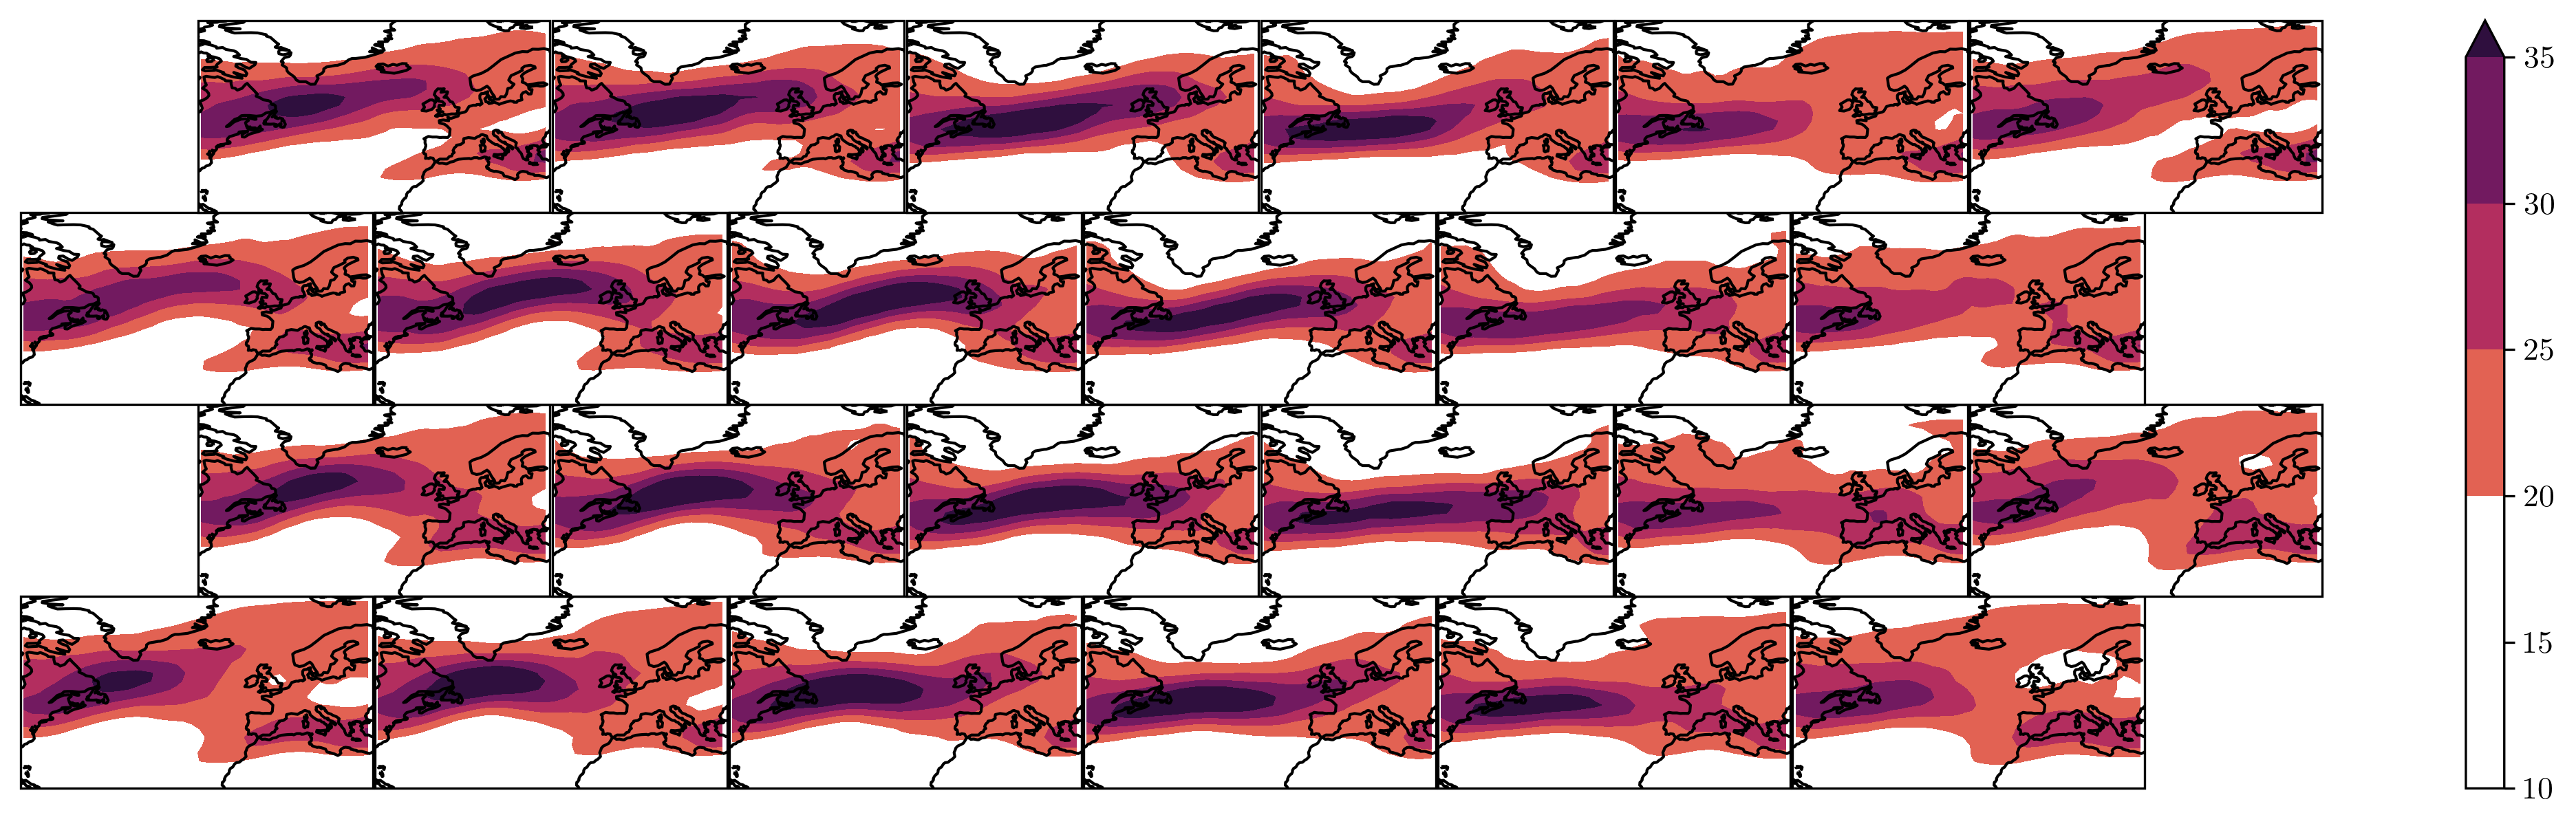

 28%|██▊       | 104/368 [00:02<00:06, 37.89it/s]


KeyboardInterrupt: 

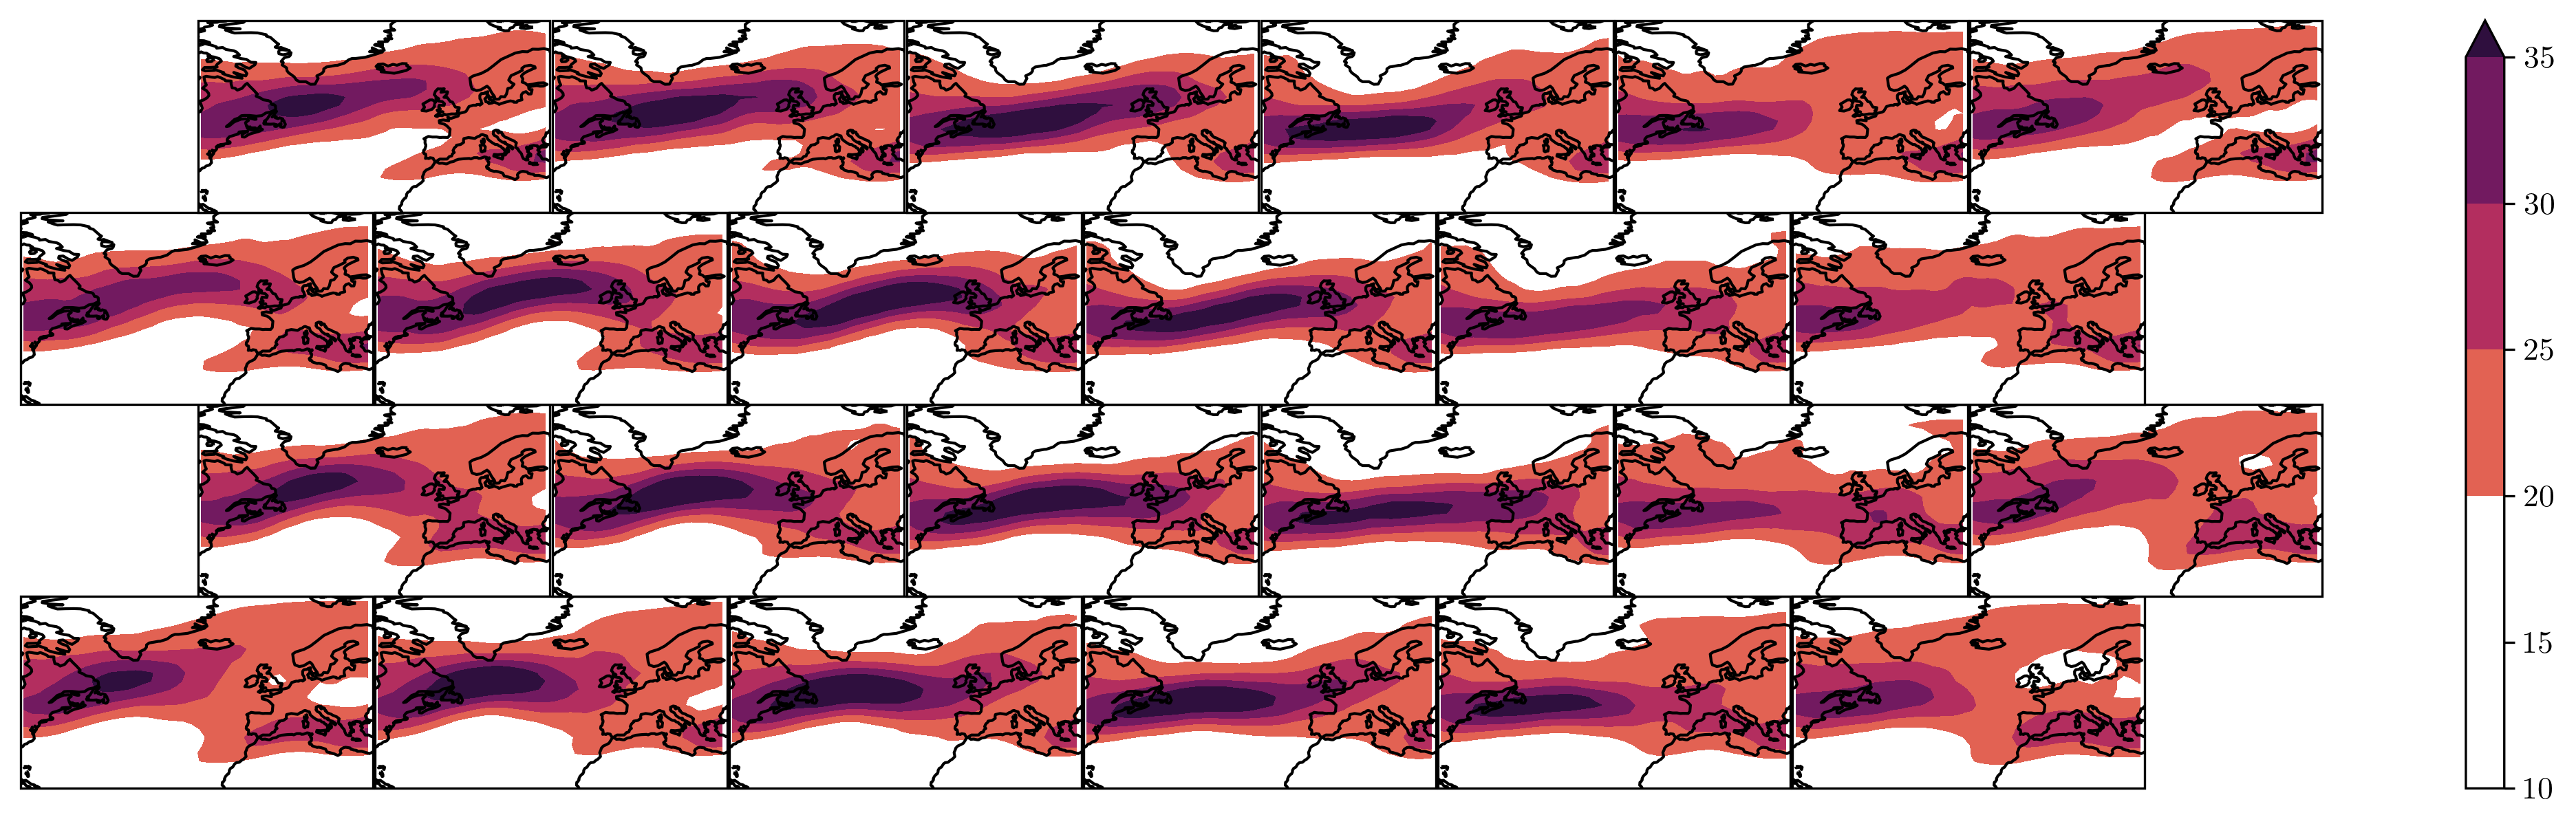

In [12]:
plt.ioff()
from IPython.display import display, clear_output
from simpsom.neighborhoods import Neighborhoods
%matplotlib inline

epochs = 100
start_sigma = 1
start_lr = 0.05
win_size = 7
nbatch = len(X_norm) // 64
lon, lat = da_s_coarse.lon.values, da_s_coarse.lat.values
nei = Neighborhoods(np, 6, 4, "hexagons", PBC=True)
neighborhood_caller = partial(nei.neighborhood_caller, neigh_func="gaussian")
size = nei.width * nei.height
weights = np.random.default_rng().random((size, *X_norm.shape[1:]), dtype=np.float32)
nodes = np.arange(size)
clu = None


def iteration_som(thisX: NDArray, weights: NDArray, nodes: NDArray, nbatch: int, win_size: int, data_range: float) -> NDArray:
    batches = np.array_split(thisX, nbatch)
    pre_numerator = np.zeros(weights.shape, dtype=np.float32)
    numerator = pre_numerator.copy()
    for batch in tqdm(batches):
        # distances = weighted_pairwise(batch, weights, weights_expvar)
        distances = pairwise_ssim(batch, weights, win_size, data_range)
        indices = np.argmin(distances, axis=1)
        
        series = indices[:, None] == nodes[None, :]
        pop = np.sum(series, axis=0, dtype=np.float32)
        for i, s in enumerate(series.T):
            pre_numerator[i, :, :] = np.sum(batch[s], axis=0)
        for i in range(pre_numerator.shape[0]):
            numerator[i, :, :] = np.sum(h[i, :, None, None] * pre_numerator, axis=0)
        
        # numerator = np.einsum('ij, jkl -> ikl', h, numerator)
        denominator = (h @ pop)[:, None, None]
        
        new_weights = np.where(denominator != 0, numerator / denominator, weights)
        weights = (1 - learning_rate) * weights + learning_rate * new_weights
        weights = weights.astype(np.float32)
    return weights


def prepare_plot(weights, lon, lat, Xmin, Xmax):
    weights = descale(weights, Xmin, Xmax)
    weights_to_plot = xr.DataArray(weights, coords={"cluster": nodes, "lat": lat, "lon": lon})
    return weights_to_plot.where(weights_to_plot > 0, 0) / norm_da


def prepare_plot_pca(weights, pca, lon, lat):
    weights_to_plot = pca.inverse_transform(weights).reshape(weights.shape[0], *da_s.shape[1:])
    weights_to_plot = xr.DataArray(weights_to_plot, coords={"cluster": nodes, "lat": lat, "lon": lon})
    return weights_to_plot.where(weights_to_plot > 0, 0) / norm_da


for epoch in range(epochs):
    sigma = start_sigma * np.exp(-epoch / epochs * 3)
    learning_rate = start_lr * np.exp(-epoch / epochs)
    thisX = X_norm.copy()
    np.random.shuffle(thisX)
    h = neighborhood_caller(nodes, sigma=sigma).astype(np.float32)
    weights = iteration_som(thisX, weights, nodes, nbatch, win_size, data_range)   
    weights_to_plot = prepare_plot(weights, lon, lat, Xmin, Xmax) 
    if clu:
        plt.close(clu.fig)
        del clu
    clear_output(wait = True)
    print(f'ite: {epoch + 1}/{epochs}, lr: {learning_rate:.2e}, sigma: {sigma:.2e}', end='\r')
    clu = Clusterplot(nei.height, nei.width, exp_s.region, honeycomb=True)
    clu.add_contourf(weights_to_plot, q=0.97, transparify=2, cmap=colormaps.matter)  
    display(clu.fig)
if clu:
    plt.close(clu.fig)
    del clu

# SOMs basic

In [3]:
net, centers, labels = exp_s.som_cluster(
    8,
    6,
    200,
    return_type=RAW_REALSPACE,
    force=False,
    train_kwargs=dict(train_algo="batch", epochs=100, start_learning_rate=0.05),
)
labels = xr.DataArray(labels, coords={"time": exp_s.samples_dims["time"]})
populations = net.compute_populations()
coords = net.neighborhoods.coordinates
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={"time": labels.time.values, "cluster": np.arange(mask.shape[1])})
# centers_all_jets = find_jets(xr.Dataset({"s": centers}))
# centers_props = compute_all_jet_props(centers_all_jets, centers)
# centers_props_ds_uncat = props_to_ds(centers_props, centers.cluster)
# centers_props_ds = categorize_ds_jets(centers_props_ds_uncat)

/storage/homefs/hb22g102/miniforge3/envs/env11/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Typical summer pathway

In [67]:
timestepwise = []
for grouplabel, group in labels.groupby(labels.time.dt.week).groups.items():
    coords = net.neighborhoods.coordinates[labels[group]]
    unique, count = np.unique(labels[group], return_counts=True)
    coordsmax = coords.max(axis=0, keepdims=True)
    thetas = coords / coordsmax * 2 * np.pi
    xi, zeta = np.cos(thetas), np.sin(thetas)
    mxi, mzeta = np.mean(xi, axis=0), np.mean(zeta, axis=0)
    stdxi, stdzeta = np.std(xi, axis=0), np.std(zeta, axis=0)
    com = np.arctan2(-mzeta, -mxi) + np.pi
    com = com / 2 / np.pi * coordsmax
    variab = np.arctan2(-stdzeta, -stdxi) + np.pi
    variab = variab / 2 / np.pi * coordsmax
    # variab = np.std(coords, axis=0)
    timestepwise.append((com.squeeze(), variab.squeeze(), unique, count))

/storage/homefs/hb22g102/miniforge3/envs/env11/lib/python3.11/site-packages/xarray/core/accessor_dt.py:441: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


In [80]:
com = np.asarray([step_[0] for step_ in timestepwise])
com_std = np.asarray([step_[1] for step_ in timestepwise])

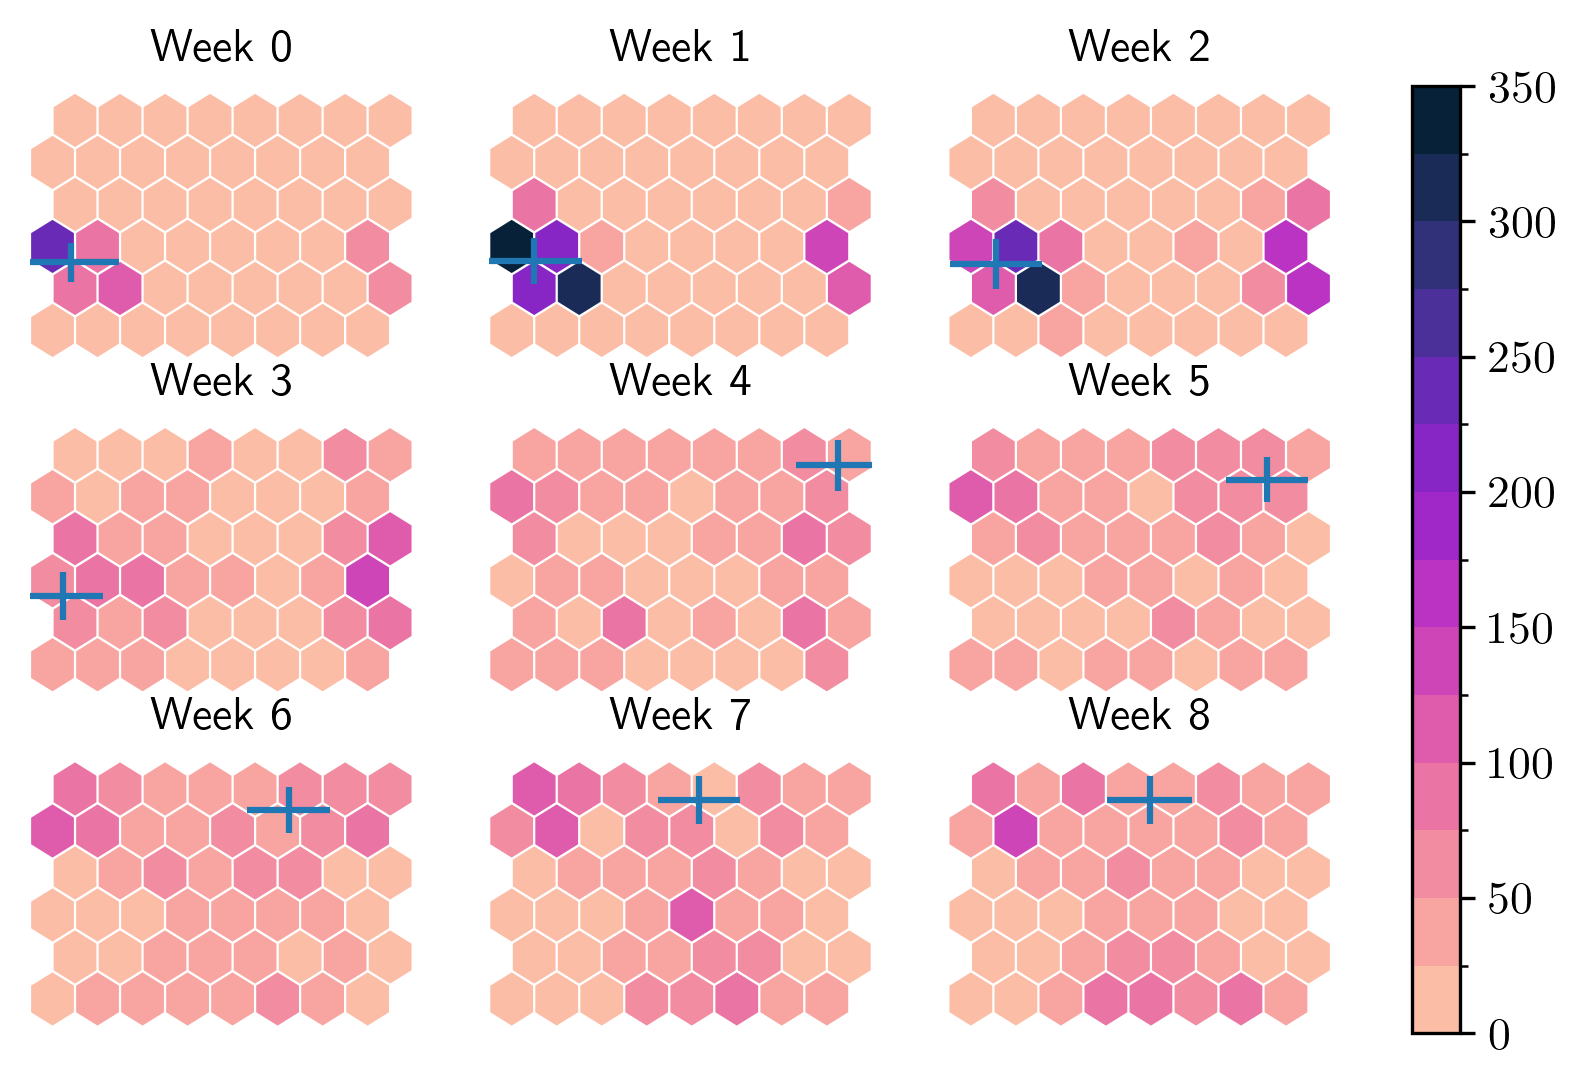

In [74]:
fig, axes = plt.subplots(3, 3, figsize=(TEXTWIDTH_IN, 4.1), tight_layout=False)
cmap = colormaps.bubblegum_r
norm = BoundaryNorm(np.arange(0, 351, 25), cmap.N)
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes)
for i, ax in enumerate(axes.ravel()):
    step = i
    unique, counts = timestepwise[step][2], timestepwise[step][3]
    to_plot = np.zeros(net.n_nodes)
    to_plot[unique] = counts
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    )
    ax.errorbar(*com[step], *com_std[step][[1, 0]])
    ax.set_title(f"Week {step}")
fig.set_tight_layout(False)

In [82]:
coords = net.neighborhoods.coordinates
com_t = np.asarray(list(map(tuple, com)), dtype="f,f")
coords_t = np.asarray(list(map(tuple, coords)), dtype="f,f")

(2.464101552963257, 8.794228553771973)

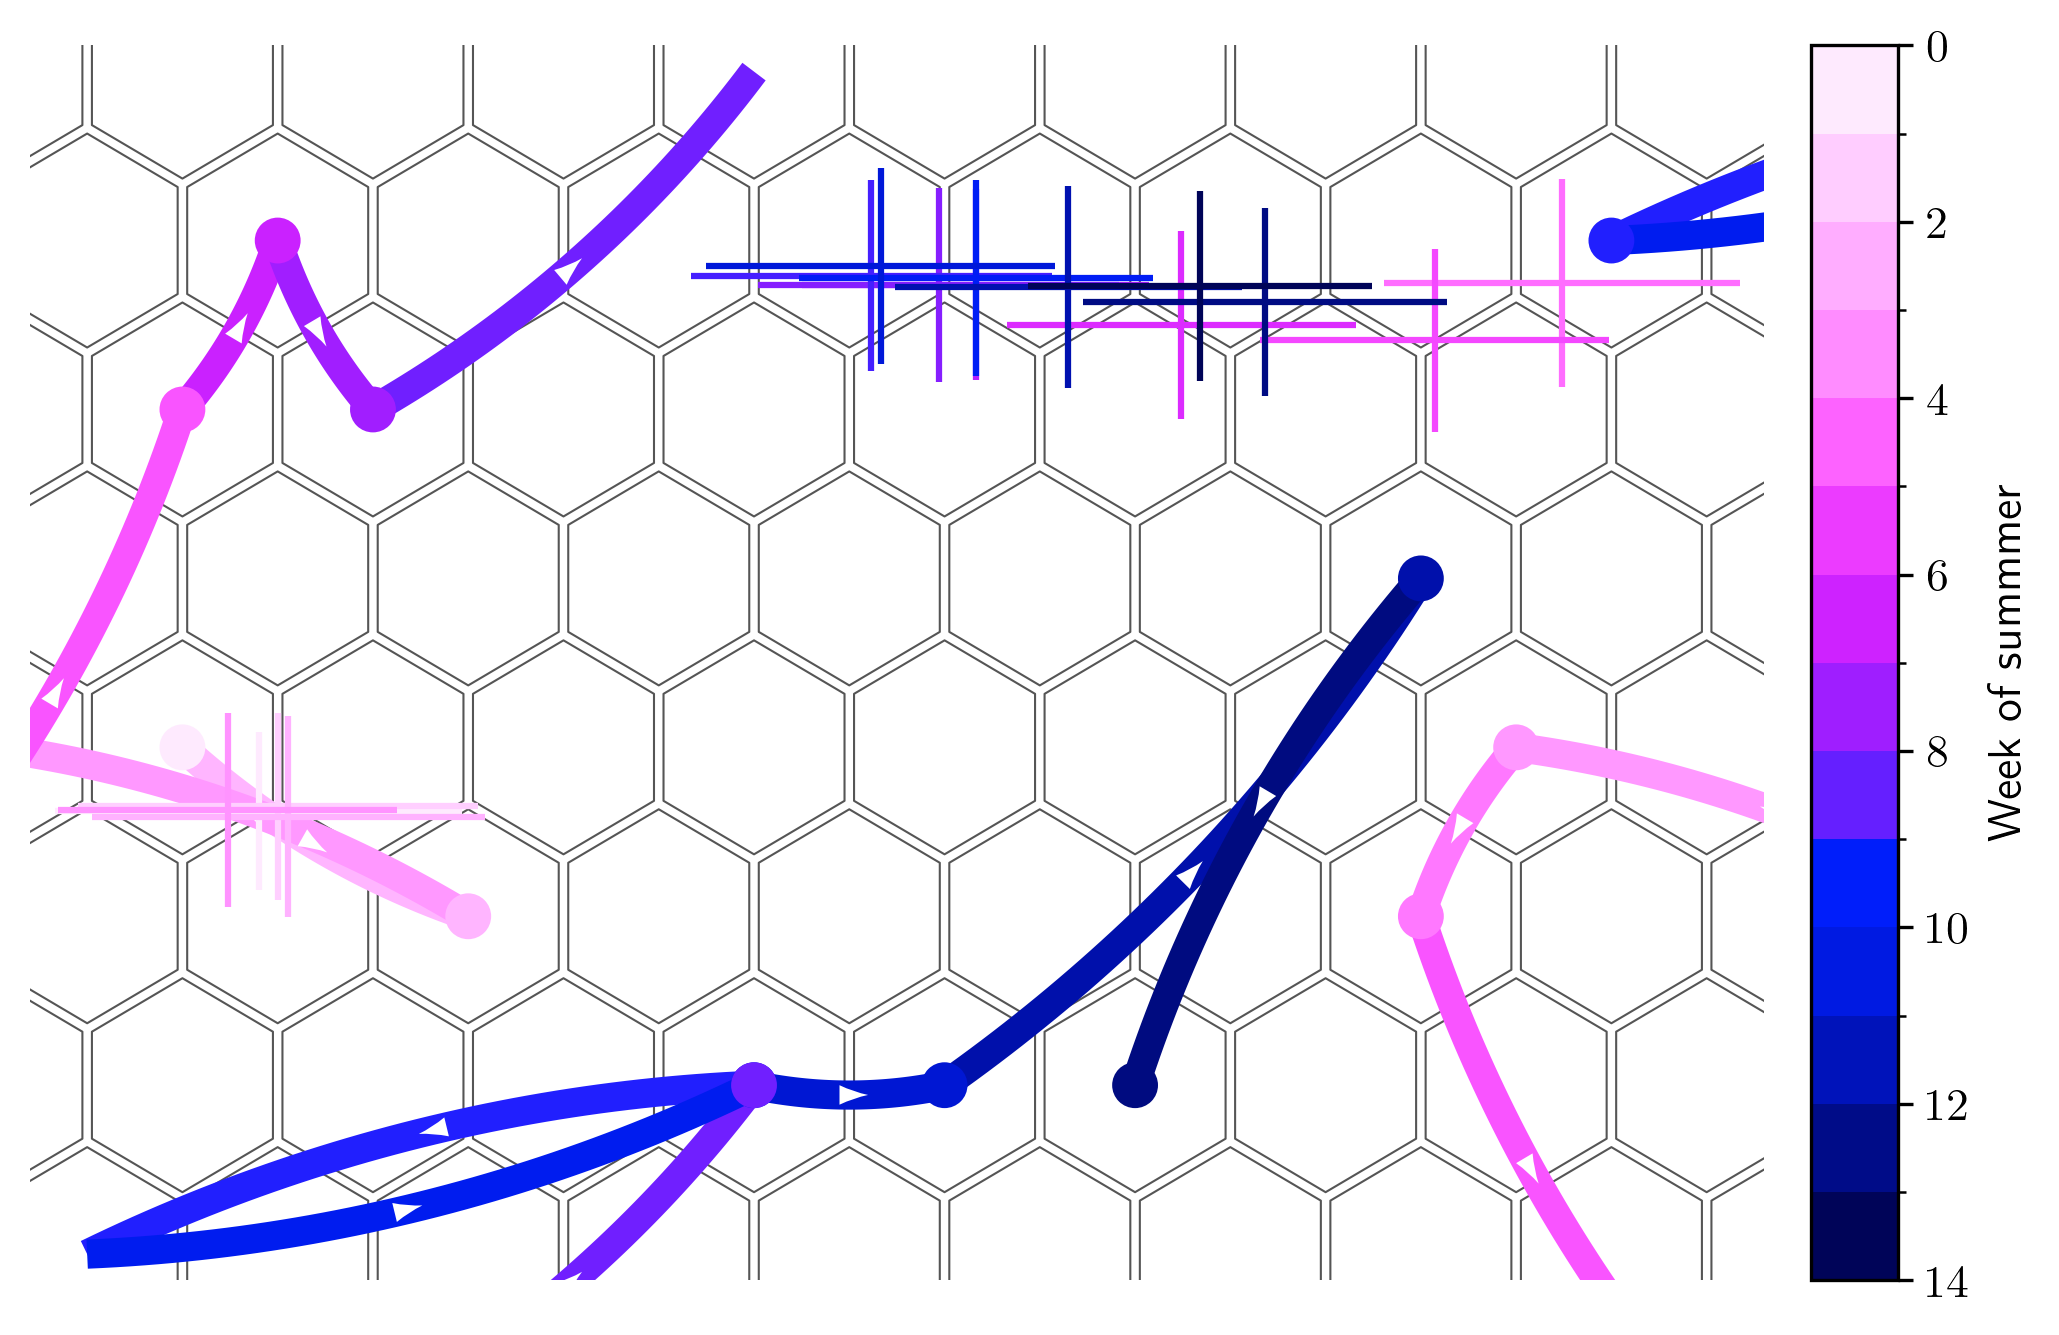

In [104]:
from simpsom.plots import create_outer_grid, traj_to_segments, segments_to_arcs, plot_map
from matplotlib.collections import PatchCollection, LineCollection

outer_grid, inner_grid, coords, outermask = create_outer_grid(net.width, net.height)
edgecolors = np.full(len(coords), "black", dtype=object)
edgecolors[outermask] = "gray"
alphas = np.ones(len(coords))
alphas[outermask] = 0.2

traj = []
for step_ in timestepwise:
    unique, counts = step_[2:]
    traj.append(unique[np.argmax(counts)])
traj = np.asarray(traj)   
# traj = np.argmin(pairwise_distances(com, net.neighborhoods.coordinates), axis=1) 
traj_split = np.split(traj, np.where((np.diff(traj) != 0))[0] + 1)
sizes = np.asarray([len(stay) for stay in traj_split])
uniques = np.asarray([stay[0] for stay in traj_split])
color_array = np.asarray([0, *np.cumsum(sizes)], dtype=int)
cmap = colormaps.cet_l_bmw1_r
colors = cmap(np.linspace(0, 1, len(traj) + 1))[color_array]
sort_like = np.argsort(sizes)[::-1]
    
segments, reps = traj_to_segments(traj_split, coords, outer_grid, outermask)
arcs, arrows = segments_to_arcs(segments)

gs = plt.GridSpec(
    1,
    3,
    width_ratios=[1, 0.02, 0.05],
    wspace=0.01,
    left=0.01,
    right=0.9,
    bottom=0.01,
    top=0.99,
)
fig = plt.figure(figsize=(TEXTWIDTH_IN, 4.2))
ax = fig.add_subplot(gs[0])
ax_cbar = fig.add_subplot(gs[2])
inner_coords = coords[~outermask]
xlims = [
    np.amin(inner_coords[:, 0]) - 0.8,
    np.amax(inner_coords[:, 0]) + 0.8,
]
ylims = [
    np.amin(inner_coords[:, 1]) - 1,
    np.amax(inner_coords[:, 1]) + 1,
]

fig, ax = plot_map(
    coords,
    np.zeros(len(coords)) + np.nan,
    "hexagons",
    draw_cbar=False,
    show=False,
    edgecolors="black",
    alphas=alphas,
    linewidths=0.5,
    fig=fig,
    ax=ax,
)

lc = LineCollection(arcs, colors=np.repeat(colors[1:-1], reps, axis=0), zorder=3)
lc.set_linewidth(7)
lc = ax.add_collection(lc)
arrows = PatchCollection(arrows, zorder=9, edgecolor=None, facecolor="white")
ax.add_collection(arrows)
im = ScalarMappable(BoundaryNorm(np.arange(0, len(traj)), cmap.N), cmap)
cbar = fig.colorbar(
    im,
    cax=ax_cbar,
    label="Week of summmer"
)
uniques = uniques[sort_like]
sizes = sizes[sort_like]
colors = colors[:-1][sort_like]
ax.scatter(*coords[~outermask][uniques].T, s=100, c=colors, zorder=10)
colors = cmap(np.linspace(0, 1, len(com)))
for color, com_, com_std_ in zip(colors, com, com_std):
    com_ = com_ + np.asarray([ 4., 3.4641 ])
    ax.errorbar(*com_, *com_std_[[1, 0]], zorder=10, color=color)

every = 4 * (len(traj) // 40 + 1)
list_of_days = np.asarray(np.arange(0, len(traj), every))
ax_cbar.invert_yaxis()
ax.set_xlim(xlims)
ax.set_ylim(ylims)

## DST

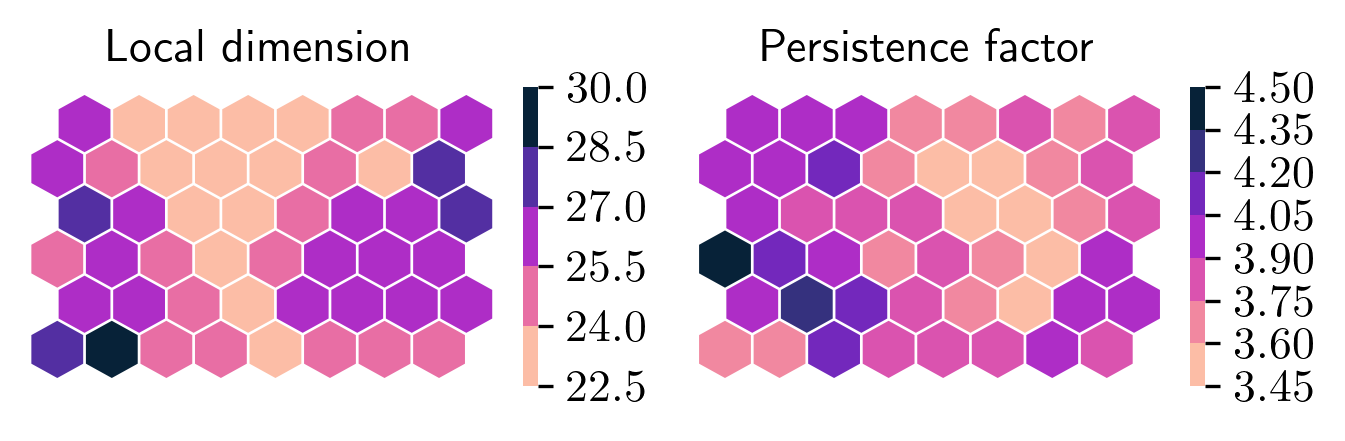

In [4]:
to_plot_ld = timeseries_on_map(ld, net.bmus)[0]
to_plot_theta = timeseries_on_map(1 / theta, net.bmus)[0]

cmap = colormaps.bubblegum_r
fig, axes = plt.subplots(1, 2, figsize=(0.66 * TEXTWIDTH_IN, 1.7), tight_layout=True)
fig, axes[0] = net.plot_on_map(
    to_plot_ld,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[0],
    discretify=True,
)
axes[0].set_title("Local dimension")
fig, axes[1] = net.plot_on_map(
    to_plot_theta,
    smooth_sigma=0,
    fig=fig,
    cmap=cmap,
    ax=axes[1],
    discretify=True,
)
axes[1].set_title("Persistence factor")
fig.savefig(f'{FIGURES}/som_props/DST.png')

## rt, multi

In [66]:
da = da_s
df = pd.read_csv(f"{DATADIR}/ERA5/daily_nao.csv", delimiter=",")
index = pd.to_datetime(df.iloc[:, :3])
series = xr.DataArray(df.iloc[:, 3].values, coords={"time": index})
nao_summer = series.interp_like(da_s)
nao_on_map = timeseries_on_map(nao_summer, net.bmus)[0]

yearly = mask_da.resample(time="1YE").sum().values
trends = np.zeros(net.n_nodes)
pvalues = trends.copy()
for k, yearly_ in enumerate(yearly.T):
    trends[k], _, _, pvalues[k], _ = linregress(
        np.arange(yearly.shape[0])[yearly_ != 0], yearly_[yearly_ != 0]
    )


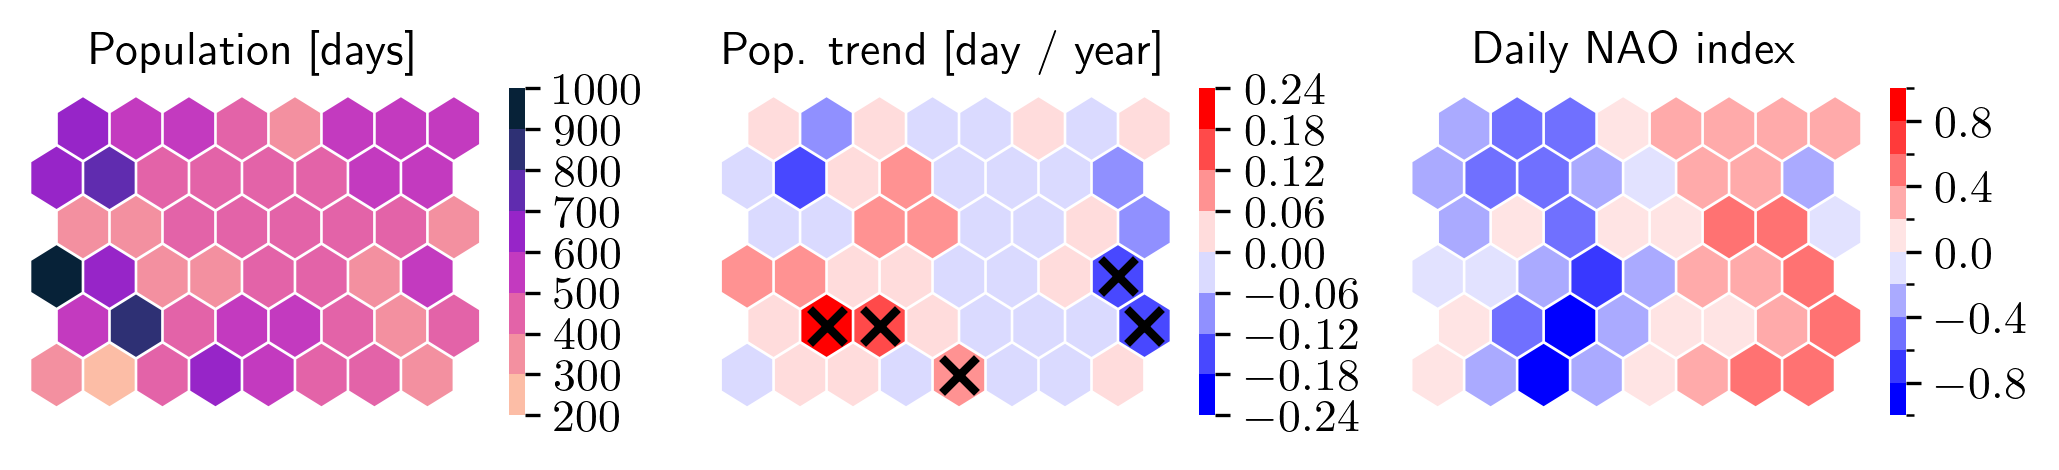

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.7), tight_layout=True)
axes = axes.ravel()
fig, axes[0] = net.plot_on_map(
    populations,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[0],
    discretify=True,
)
axes[0].set_title("Population [days]")
fig, axes[1] = net.plot_on_map(
    trends,
    smooth_sigma=0,
    show=False,
    cmap="bwr",
    discretify=True,
    fig=fig,
    ax=axes[1],
)
coords = net.neighborhoods.coordinates[np.where(pvalues < 0.05)[0]]
axes[1].scatter(*coords.T, s=70, c="black", marker="x", linewidths=2)
axes[1].set_title("Pop. trend [day / year]")
fig, axes[2] = net.plot_on_map(
    nao_on_map,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=axes[2],
    cmap="bwr",
    discretify=True,
)
axes[2].set_title("Daily NAO index")
fig.savefig(f'{FIGURES}/som_props/pop_trend_nao.png')

In [7]:
da_pvs = Experiment("ERA5", "surf", "pvs", "6H", "all", "JJA", *exp_s.region, 250, "hourofyear", {"hourofyear": ("win", 60)}).da

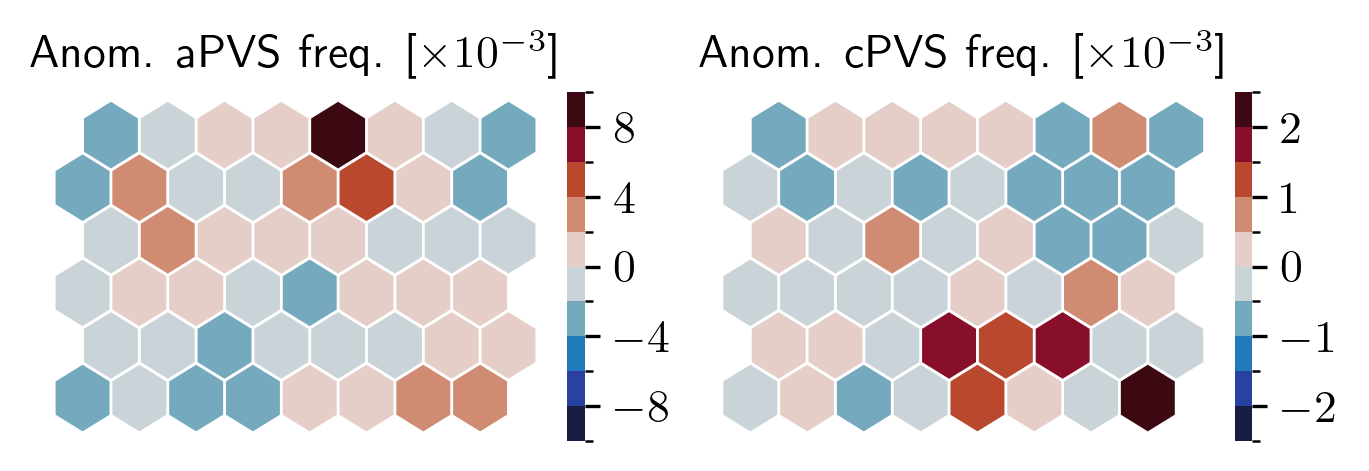

In [58]:
time_mask = np.isin(labels.time.values, da_pvs.time.values)
to_plot_anti = np.asarray([da_pvs.loc[:, 'anti'][mask_[time_mask]].mean().item() for mask_ in mask.T])
to_plot_cycl = np.asarray([da_pvs.loc[:, 'cycl'][mask_[time_mask]].mean().item() for mask_ in mask.T])

fig, axes = plt.subplots(1, 2, figsize=(0.66 * TEXTWIDTH_IN, 1.7), tight_layout=True)
fig, axes[0] = net.plot_on_map(
    to_plot_anti * 1000,
    smooth_sigma=0,
    show=False,
    cmap=colormaps.balance,
    fig=fig,
    ax=axes[0],
    discretify=True,
)
axes[0].set_title(r"Anom. aPVS freq. [$\times 10^{-3}$]")
fig, axes[1] = net.plot_on_map(
    to_plot_cycl * 1000,
    smooth_sigma=0,
    fig=fig,
    cmap=colormaps.balance,
    ax=axes[1],
    discretify=True,
)
axes[1].set_title(r"Anom. cPVS freq. [$\times 10^{-3}$]")
fig.savefig(f'{FIGURES}/som_props/PVS_activity.png')

In [59]:
yearbreak = np.sum(da_s.time.dt.year.values == 1999)
mean_res, max_res, trend_res, pvalues = net.compute_residence_time(0, yearbreak=yearbreak)

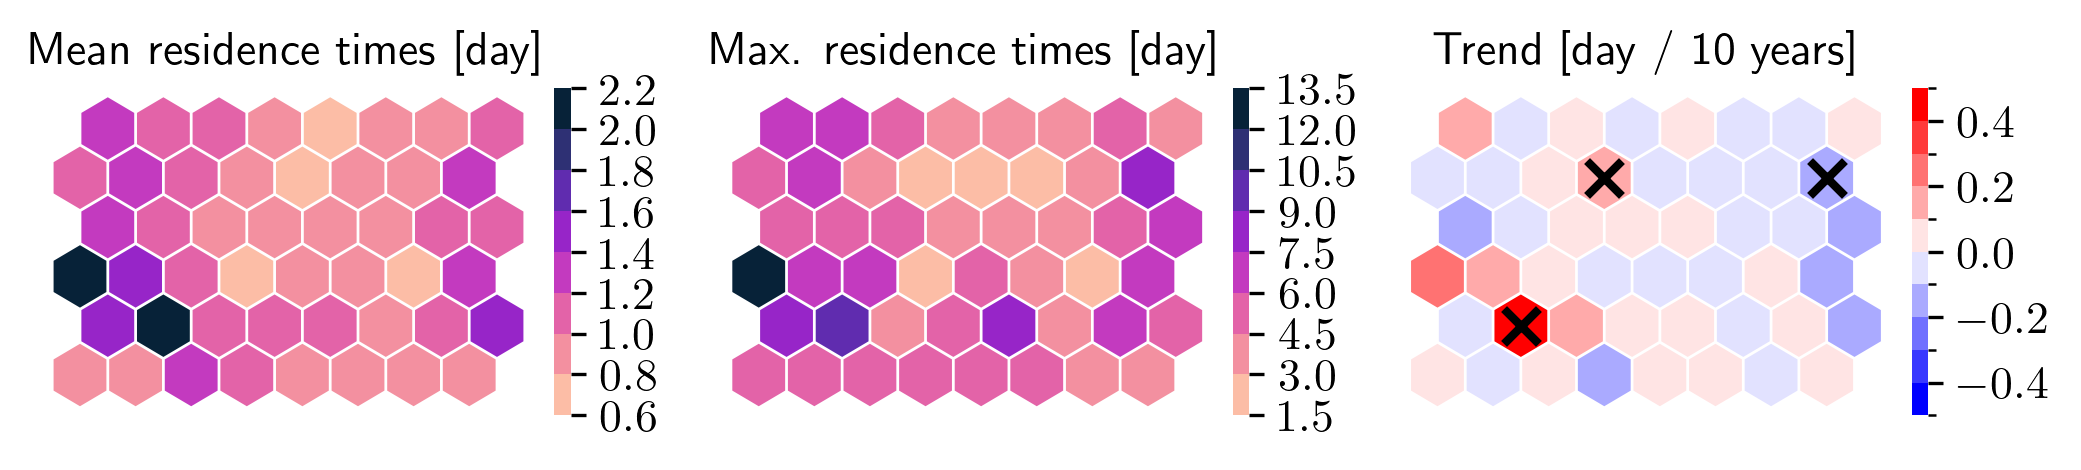

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.7), tight_layout=True)
axes = axes.ravel()
fig, axes[0] = net.plot_on_map(
    mean_res / 4,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[0],
    discretify=True,
)
axes[0].set_title("Mean residence times [day]")
fig, axes[1] = net.plot_on_map(
    max_res / 4,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[1],
    discretify=True,
)
axes[1].set_title("Max. residence times [day]")
fig, axes[2] = net.plot_on_map(
    trend_res / 4 * 10,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=axes[2],
    cmap="bwr",
    discretify=True,
)
axes[2].set_title("Trend [day / 10 years]")
coords = net.neighborhoods.coordinates[np.where(pvalues < 0.05)[0]]
axes[2].scatter(*coords.T, s=70, c="black", marker="x", linewidths=2)
fig.savefig(f'{FIGURES}/som_props/residence.png')

In [61]:
yearbreak = np.sum(da_s.time.dt.year.values == 1999)
mean_res, max_res, trend_res, pvalues = net.compute_residence_time(1, yearbreak=yearbreak)

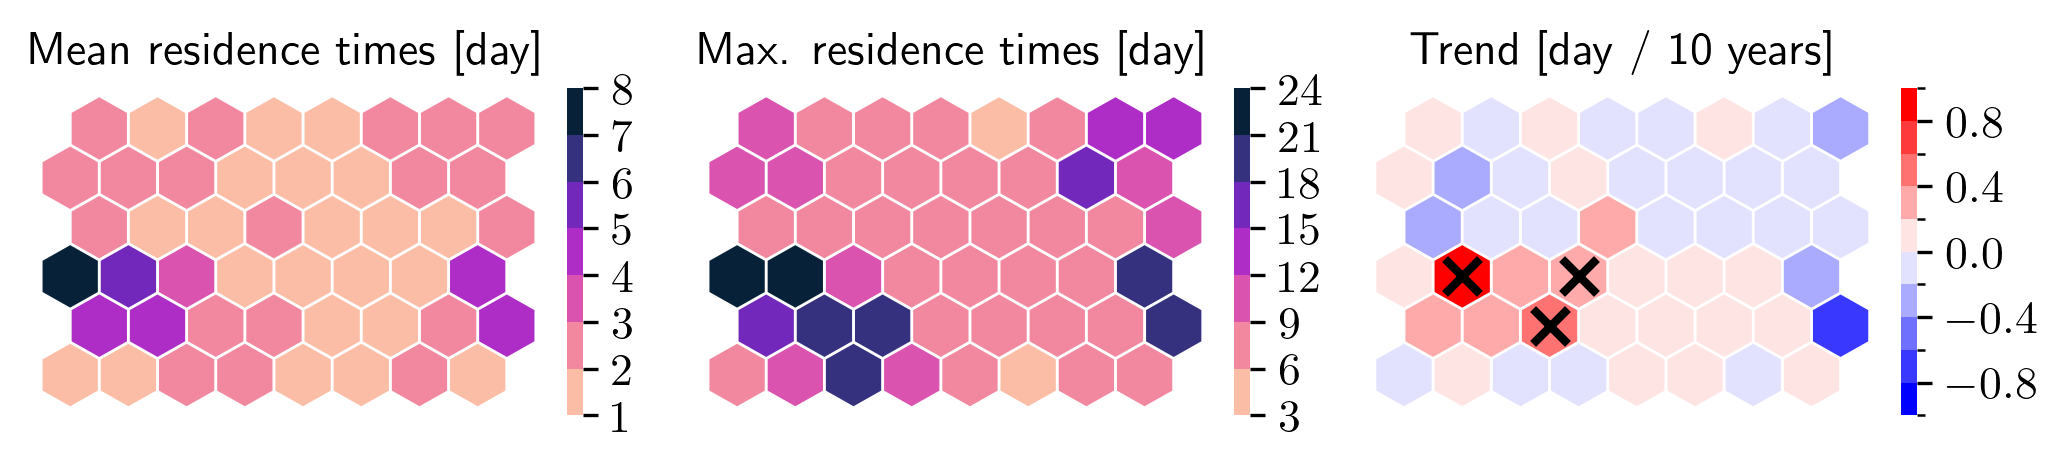

In [62]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.7), tight_layout=True)
axes = axes.ravel()
fig, axes[0] = net.plot_on_map(
    mean_res / 4,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[0],
    discretify=True,
)
axes[0].set_title("Mean residence times [day]")
fig, axes[1] = net.plot_on_map(
    max_res / 4,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[1],
    discretify=True,
)
axes[1].set_title("Max. residence times [day]")
fig, axes[2] = net.plot_on_map(
    trend_res / 4 * 10,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=axes[2],
    cmap="bwr",
    discretify=True,
)
axes[2].set_title("Trend [day / 10 years]")
coords = net.neighborhoods.coordinates[np.where(pvalues < 0.05)[0]]
axes[2].scatter(*coords.T, s=70, c="black", marker="x", linewidths=2)
fig.savefig(f'{FIGURES}/som_props/residence_sigma1.png')

## lagged backwards diffusion

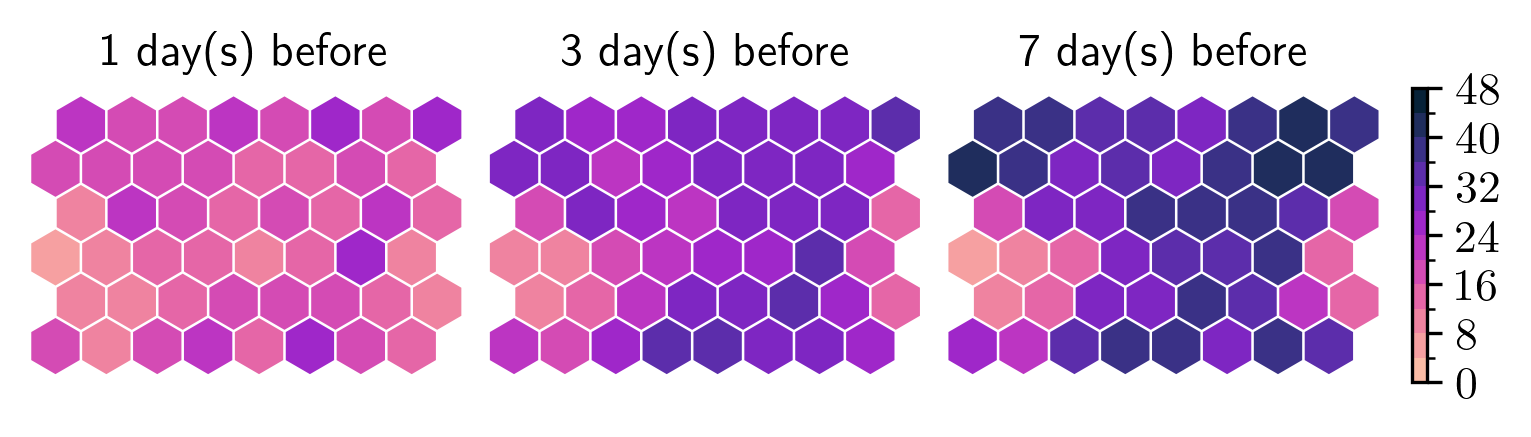

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.), gridspec_kw=dict(wspace=0.06, hspace=0.02, bottom=0.00, top=0.98), tight_layout=False)
axes = axes.ravel()
norm = BoundaryNorm(np.arange(0, net.n_nodes + 4, 4), cmap.N)
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, pad=0.02)
steps = [4, 12, 28]
for step, ax in zip(steps, axes):
    transmat = net.compute_transmat(step=step, yearbreaks=yearbreak)
    dilution = np.sum(transmat > 0.01, axis=0)
    fig, ax = net.plot_on_map(
        dilution,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    ) 
    ax.set_title(f"{step // 4} day(s) before")
fig.set_tight_layout(False)
fig.savefig(f'{FIGURES}/som_props/dilution_before.png')

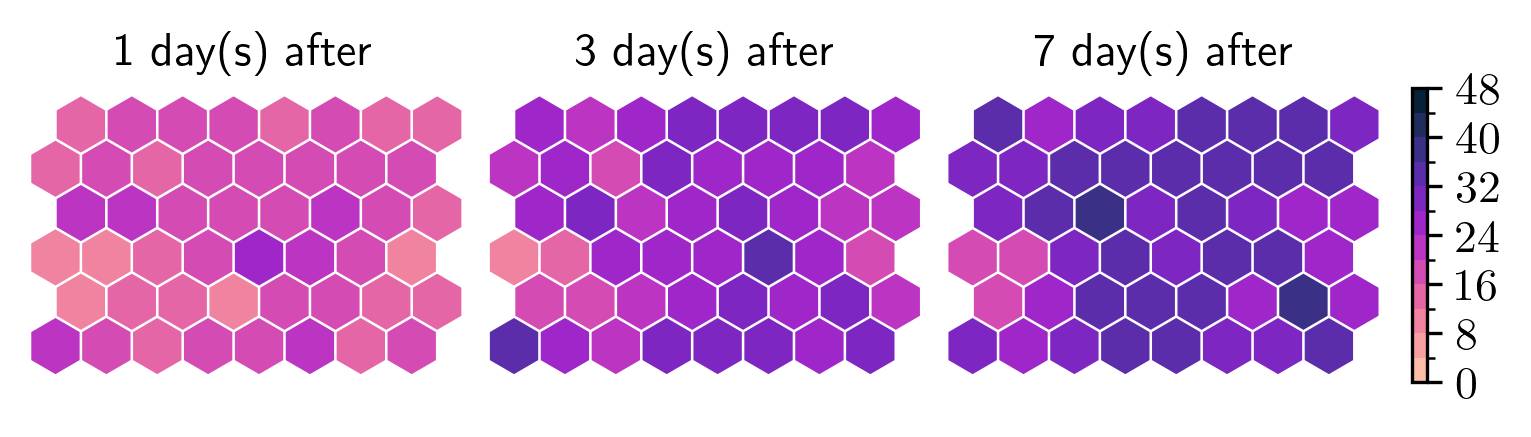

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.), gridspec_kw=dict(wspace=0.06, hspace=0.02, bottom=0.00, top=0.98), tight_layout=False)
axes = axes.ravel()
norm = BoundaryNorm(np.arange(0, net.n_nodes + 4, 4), cmap.N)
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, pad=0.02)
steps = [4, 12, 28]
for step, ax in zip(steps, axes):
    transmat = net.compute_transmat(step=step, yearbreaks=yearbreak)
    dilution = np.sum(transmat > 0.01, axis=1)
    fig, ax = net.plot_on_map(
        dilution,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    ) 
    ax.set_title(f"{step // 4} day(s) after")
fig.set_tight_layout(False)
fig.savefig(f'{FIGURES}/som_props/dilution_after.png')

## lagged backwards transitions

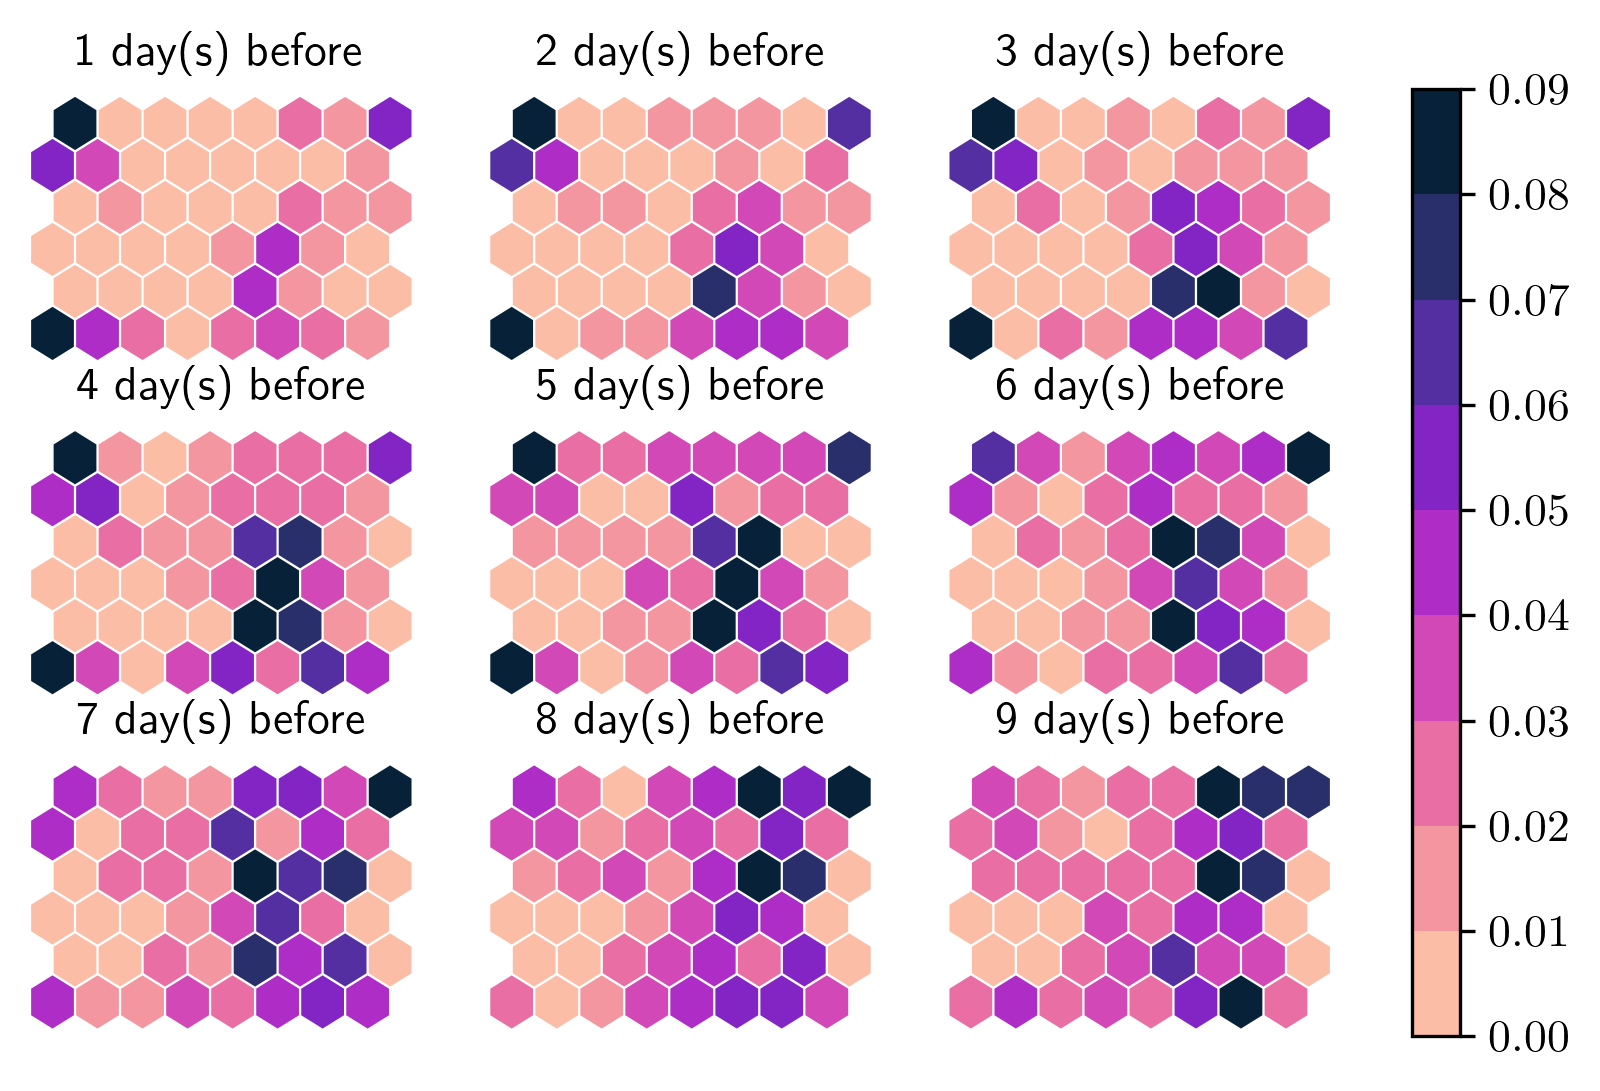

In [25]:
fig, axes = plt.subplots(3, 3, figsize=(TEXTWIDTH_IN, 4.1), tight_layout=False)
norm = BoundaryNorm(np.arange(0.0, .1, .01), cmap.N)
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes)
to_ = 5
for i, ax in enumerate(axes.ravel()):
    step = 4 * (i + 1)
    transmat = net.compute_transmat(step=step, yearbreaks=yearbreak)[:, to_]
    fig, ax = net.plot_on_map(
        transmat,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    )
    ax.set_title(f"{step // 4} day(s) before")
fig.set_tight_layout(False)

# SOM speed vs. COM speed

In [26]:
distances = net.neighborhoods.distances
speed = distances[labels.values[:-1], labels.values[1:]]
speed = np.append(speed, 0)
speed = labels.copy(data=speed)
speed[::yearbreak] = 0

In [27]:
com_speed = props_as_ds_summer["com_speed"].where(~props_as_ds_summer["com_speed"].isnull(), 0).values

In [47]:
speed.values[:, None].shape

(23552, 1)

In [52]:
np.corrcoef(np.concatenate([speed.values[:, None], com_speed], axis=1), rowvar=False)

array([[ 1.     , -0.01322,  0.02131],
       [-0.01322,  1.     ,  0.01973],
       [ 0.02131,  0.01973,  1.     ]])

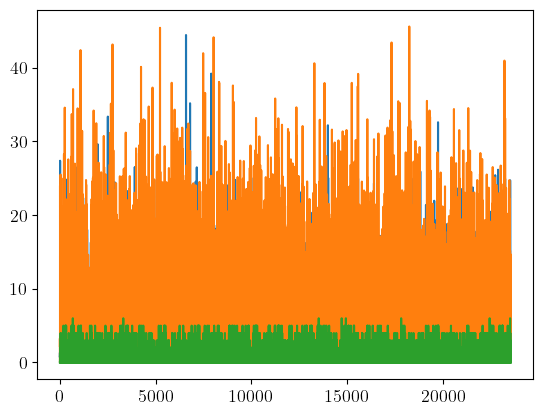

In [51]:
plt.plot(com_speed[:, 0])
plt.plot(com_speed[:, 1])
plt.plot(speed.values)

# jet indices

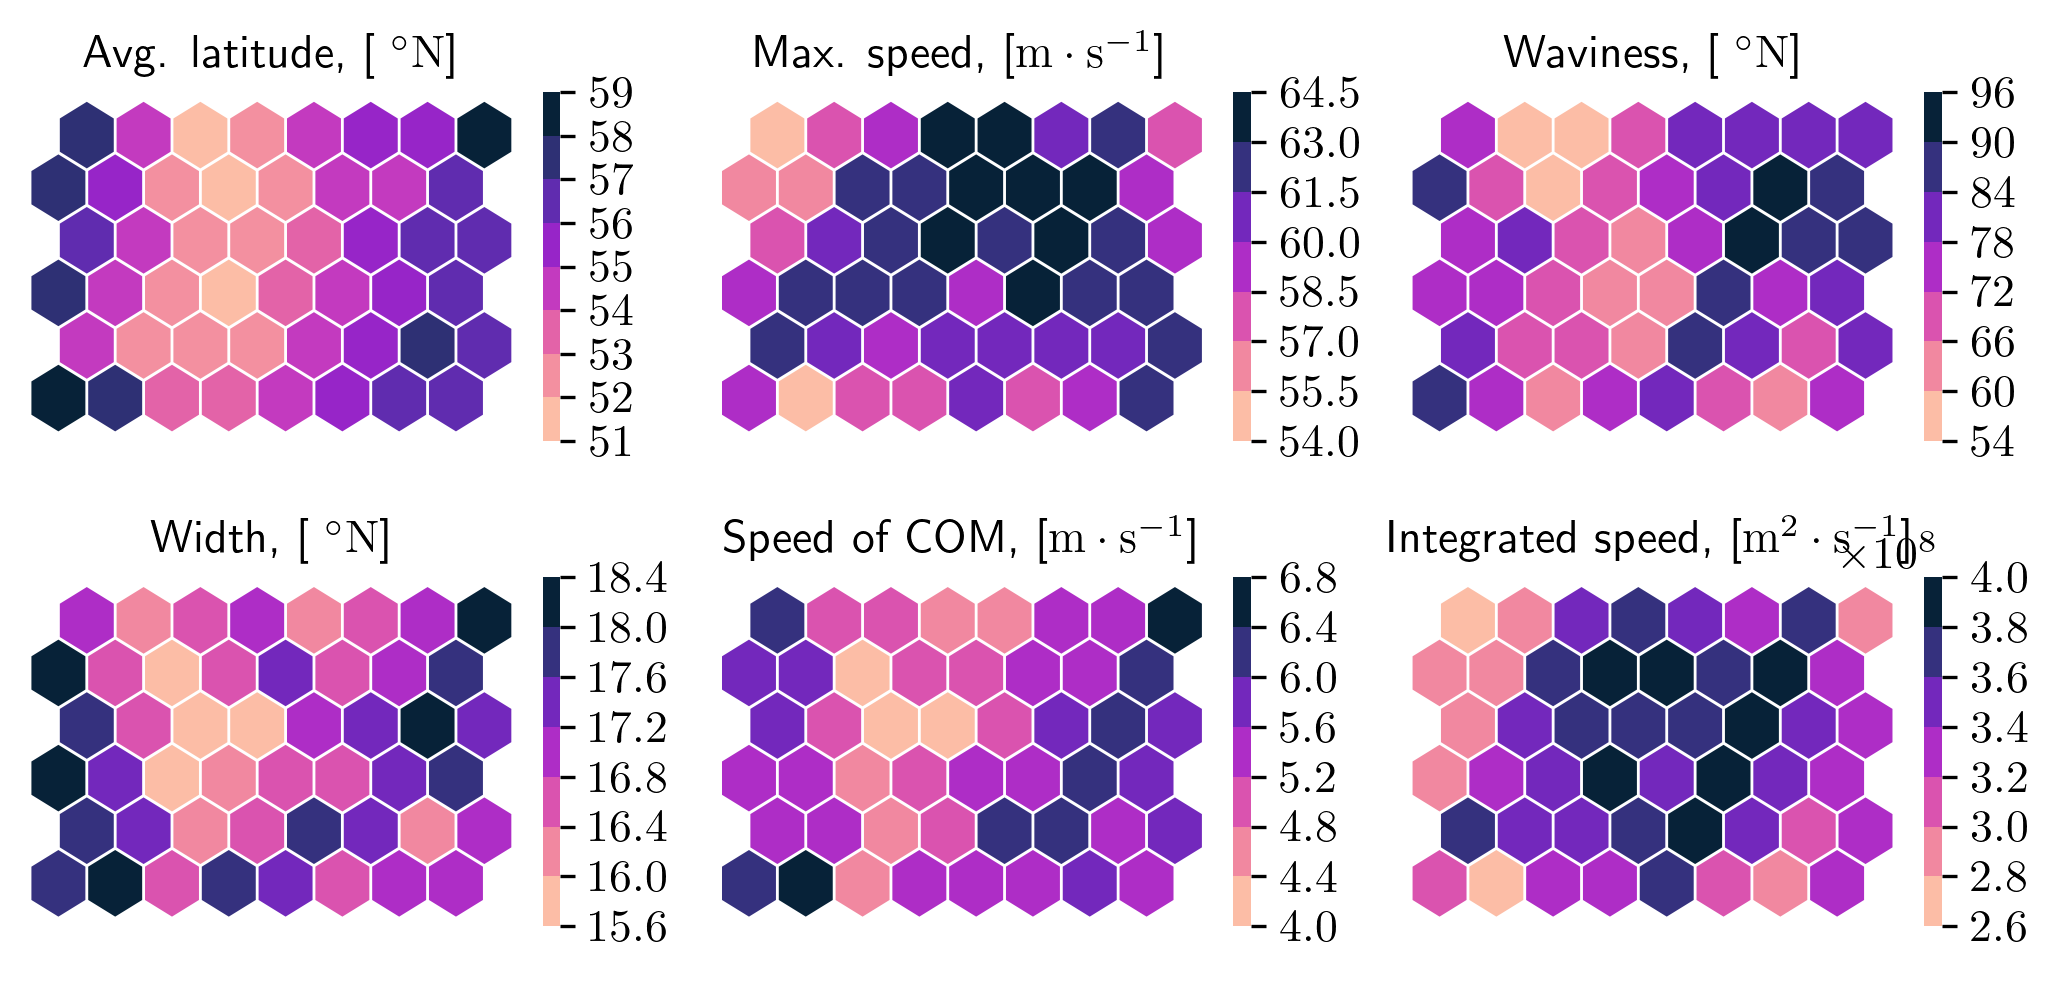

In [65]:
data_vars = ["mean_lat", "Spe", "waviness", "width", "com_speed", "int"]
cmap = colormaps.bubblegum_r
jet = "polar"

fig, axes = plt.subplots(2, 3, figsize=(TEXTWIDTH_IN, 3.4), tight_layout=True, sharex="all")
axes = axes.flatten()
for varname, ax in zip(data_vars, axes):
    try:
        to_plot = props_as_ds_summer[varname].sel(jet=jet)
    except KeyError:
        to_plot = props_as_ds_summer[varname]
    to_plot = timeseries_on_map(to_plot, net.bmus)[0]
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        fig=fig,
        ax=ax,
        draw_cbar=True,
        cmap=cmap,
        discretify=True,
    )
    ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}]")
fig.savefig(f'{FIGURES}/som_props/polar_indices.png')

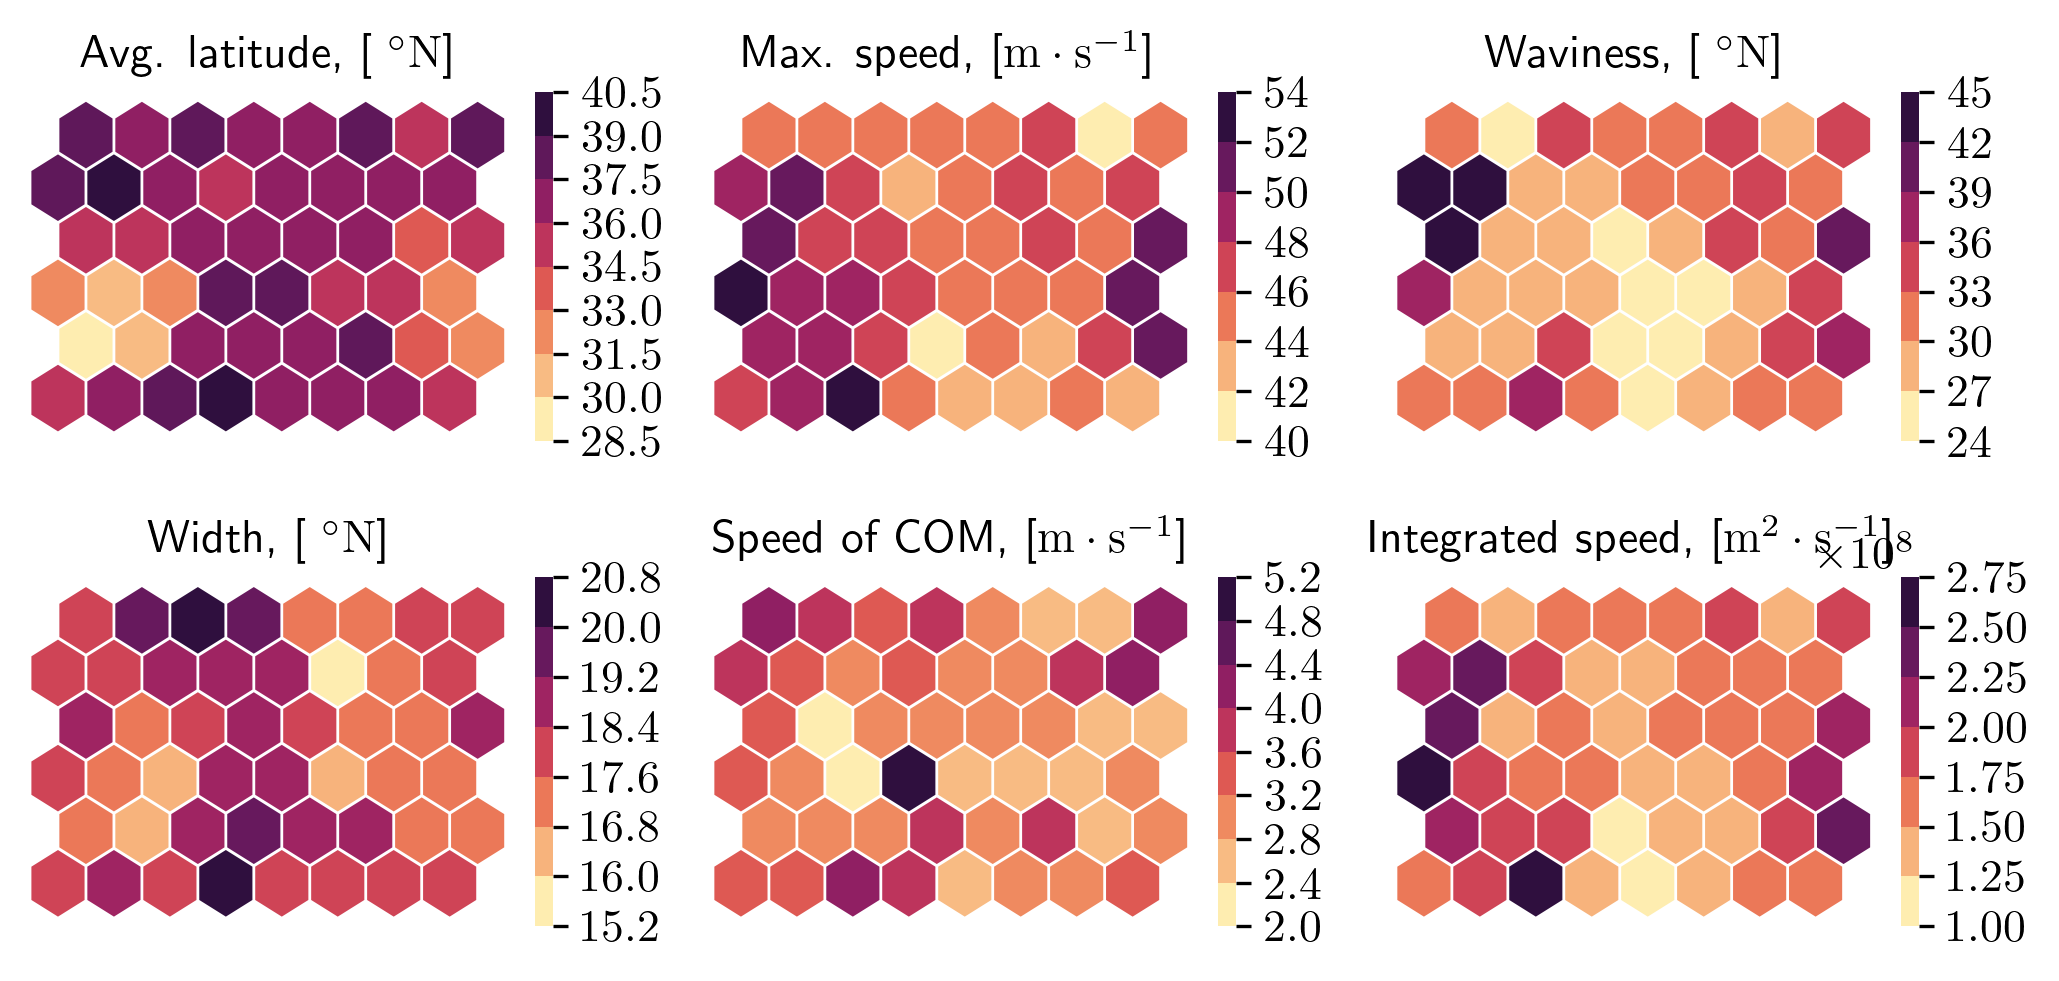

In [64]:
data_vars = ["mean_lat", "Spe", "waviness", "width", "com_speed", "int"]
cmap = colormaps.matter
jet = "subtropical"

fig, axes = plt.subplots(2, 3, figsize=(TEXTWIDTH_IN, 3.4), tight_layout=True, sharex="all")
axes = axes.flatten()
for varname, ax in zip(data_vars, axes):
    try:
        to_plot = props_as_ds_summer[varname].sel(jet=jet)
    except KeyError:
        to_plot = props_as_ds_summer[varname]
    to_plot = timeseries_on_map(to_plot, net.bmus)[0]
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        fig=fig,
        ax=ax,
        draw_cbar=True,
        cmap=cmap,
        discretify=True,
    )
    ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}]")
fig.savefig(f'{FIGURES}/som_props/subtropical_indices.png')

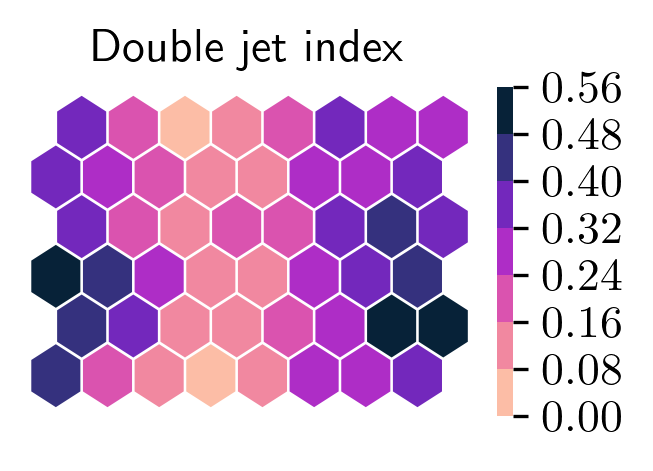

In [63]:
varname = "double_jet_index"
cmap = colormaps.bubblegum_r

fig, ax = plt.subplots(1, 1, figsize=(0.33 * TEXTWIDTH_IN, 1.7), tight_layout=True, sharex="all")
to_plot = props_as_ds_summer[varname]
to_plot = timeseries_on_map(to_plot, net.bmus)[0]
fig, ax = net.plot_on_map(
    to_plot,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=ax,
    draw_cbar=True,
    cmap=cmap,
    discretify=True,
)
ax.set_title(f"{PRETTIER_VARNAME[varname]}")
fig.savefig(f'{FIGURES}/som_props/double_jet_index.png')